In [22]:
import os
import re
import csv
import time
import torch
import shutil
import random
import joblib
import pickle
import warnings
import numpy as np
import pandas as pd
import transformers
import seaborn as sns
from tqdm import tqdm
from plotnine import *
import sklearn.exceptions
from itertools import cycle
from ast import literal_eval
from datasets import Dataset
from functools import partial
from datetime import datetime
from torch.optim import AdamW
import matplotlib.pyplot as plt
from collections import Counter
from scipy.special import softmax
from sklearn.preprocessing import label_binarize
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from mizani.formatters import percent_format, label_comma
from transformers_interpret import SequenceClassificationExplainer
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GroupShuffleSplit, StratifiedGroupKFold
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, multilabel_confusion_matrix, accuracy_score, precision_recall_fscore_support, balanced_accuracy_score
from transformers import BertTokenizer, RobertaTokenizer, RobertaModel, Trainer, BertForSequenceClassification, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding, default_data_collator

warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [2]:
# Data
gral_path = os.path.abspath("")
input_path = os.path.join(gral_path,'data','inputs','labeled')
notas_df = pd.read_csv(os.path.join(input_path,'notas_prensa_bcrp_v2.0.csv'), encoding='utf8')
notas_df.iloc[:,4:8] = notas_df.iloc[:,4:8].applymap(literal_eval)
notas_df_ = notas_df.iloc[:,[1,2,-2]]

C:\Users\Diego\AppData\Local\Temp\ipykernel_18280\1657059133.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


# Exploring topic distribution and semantics within topics

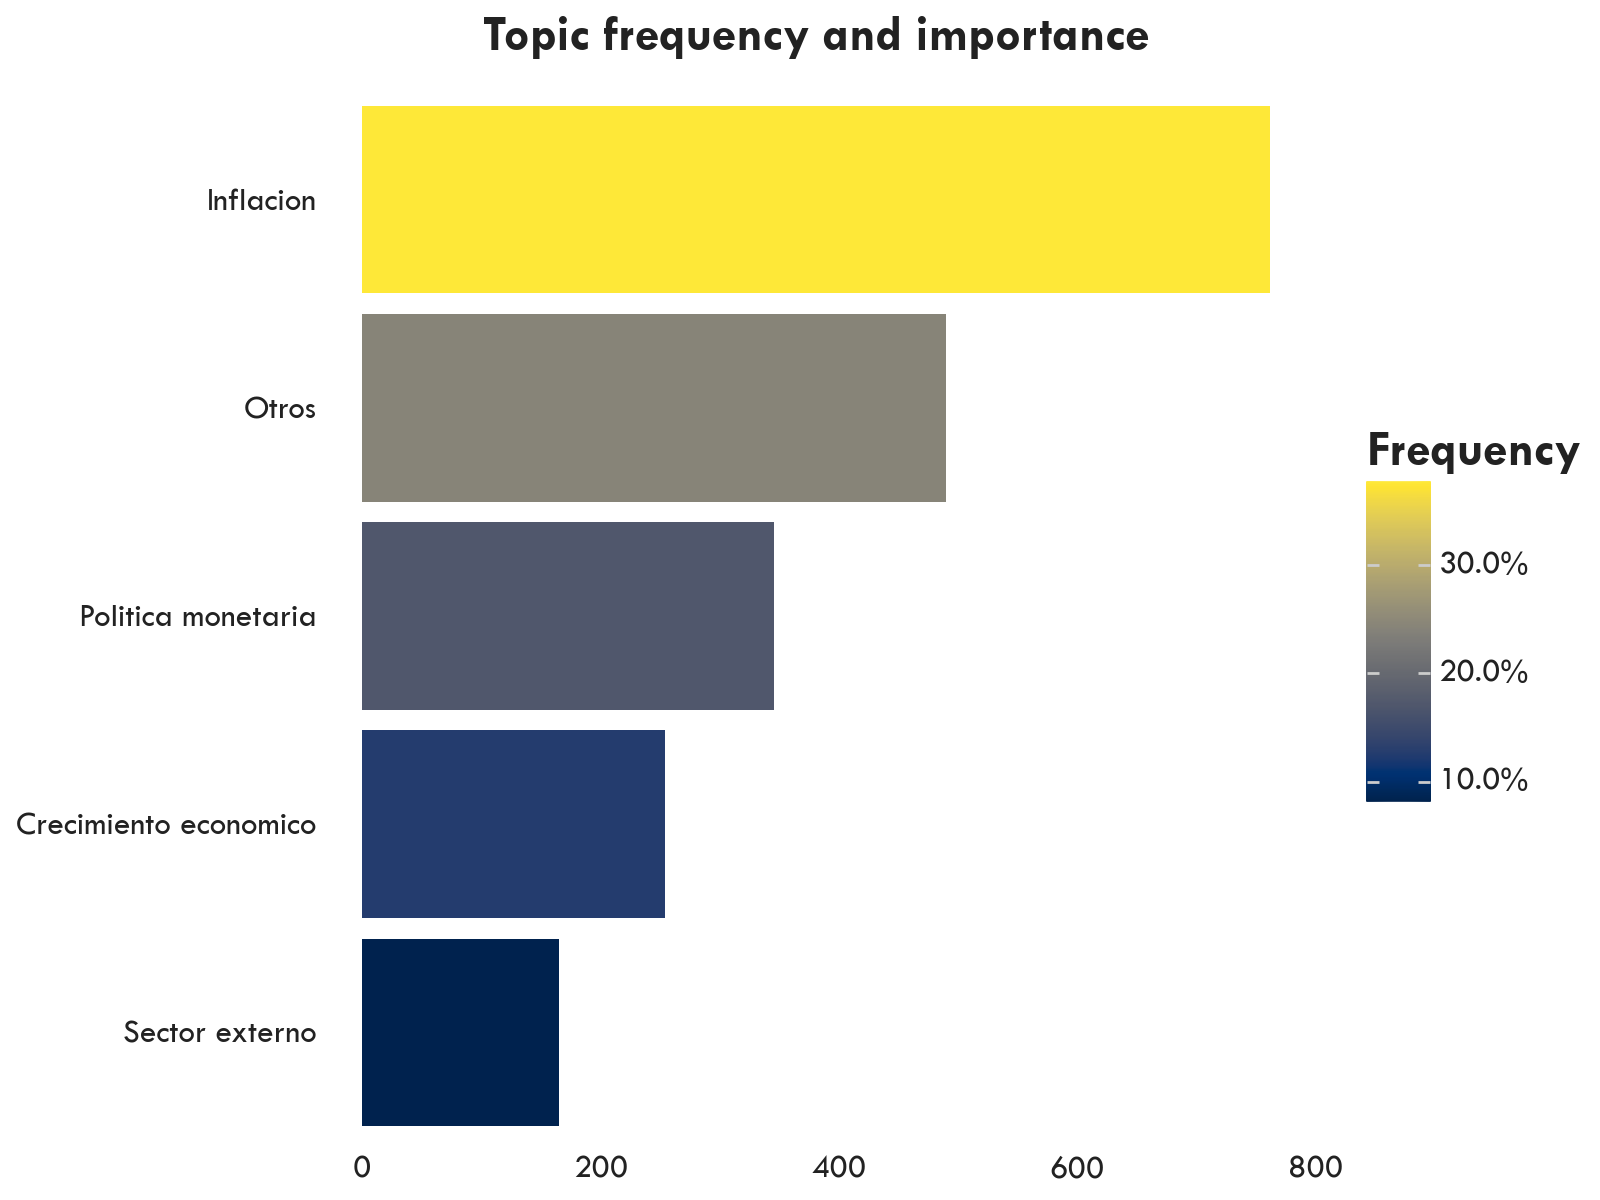

In [3]:
# Understanding topic frequency
freq_df = notas_df_.groupby('TOPIC').agg(N = pd.NamedAgg('TOPIC','count')).reset_index(drop=False)
freq_df['PCT'] = freq_df['N']/notas_df_.shape[0]

plot = ggplot(freq_df,aes('reorder(TOPIC,N)','N', fill='PCT'))
plot = plot + geom_bar(stat='identity')
plot = plot + coord_flip()
plot = plot + ggtitle(f'Topic frequency and importance')
plot = plot + scale_y_continuous(labels=label_comma())
plot = plot + scale_fill_continuous(cmap_name='cividis',labels=percent_format(accuracy=.1),name='Frequency')
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_title=element_blank(),axis_ticks = element_blank(),axis_line = element_blank(),axis_text=element_text(family="Tw Cen MT",size=12,color="#222222"))
plot = plot + theme(legend_background = element_blank(),legend_title=element_text(family="Tw Cen MT",size=18,color="#222222",face='bold'),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot = plot + theme(figure_size=(8,6))
plot

In [4]:
x = 'Inflacion'
monograms = notas_df.loc[notas_df['TOPIC']==x,'MONOGRAMS']
bigrams = notas_df.loc[notas_df['TOPIC']==x,'BIGRAMS']
trigrams = notas_df.loc[notas_df['TOPIC']==x,'TRIGRAMS']
quadrigrams = notas_df.loc[notas_df['TOPIC']==x,'QUADRIGRAMS']

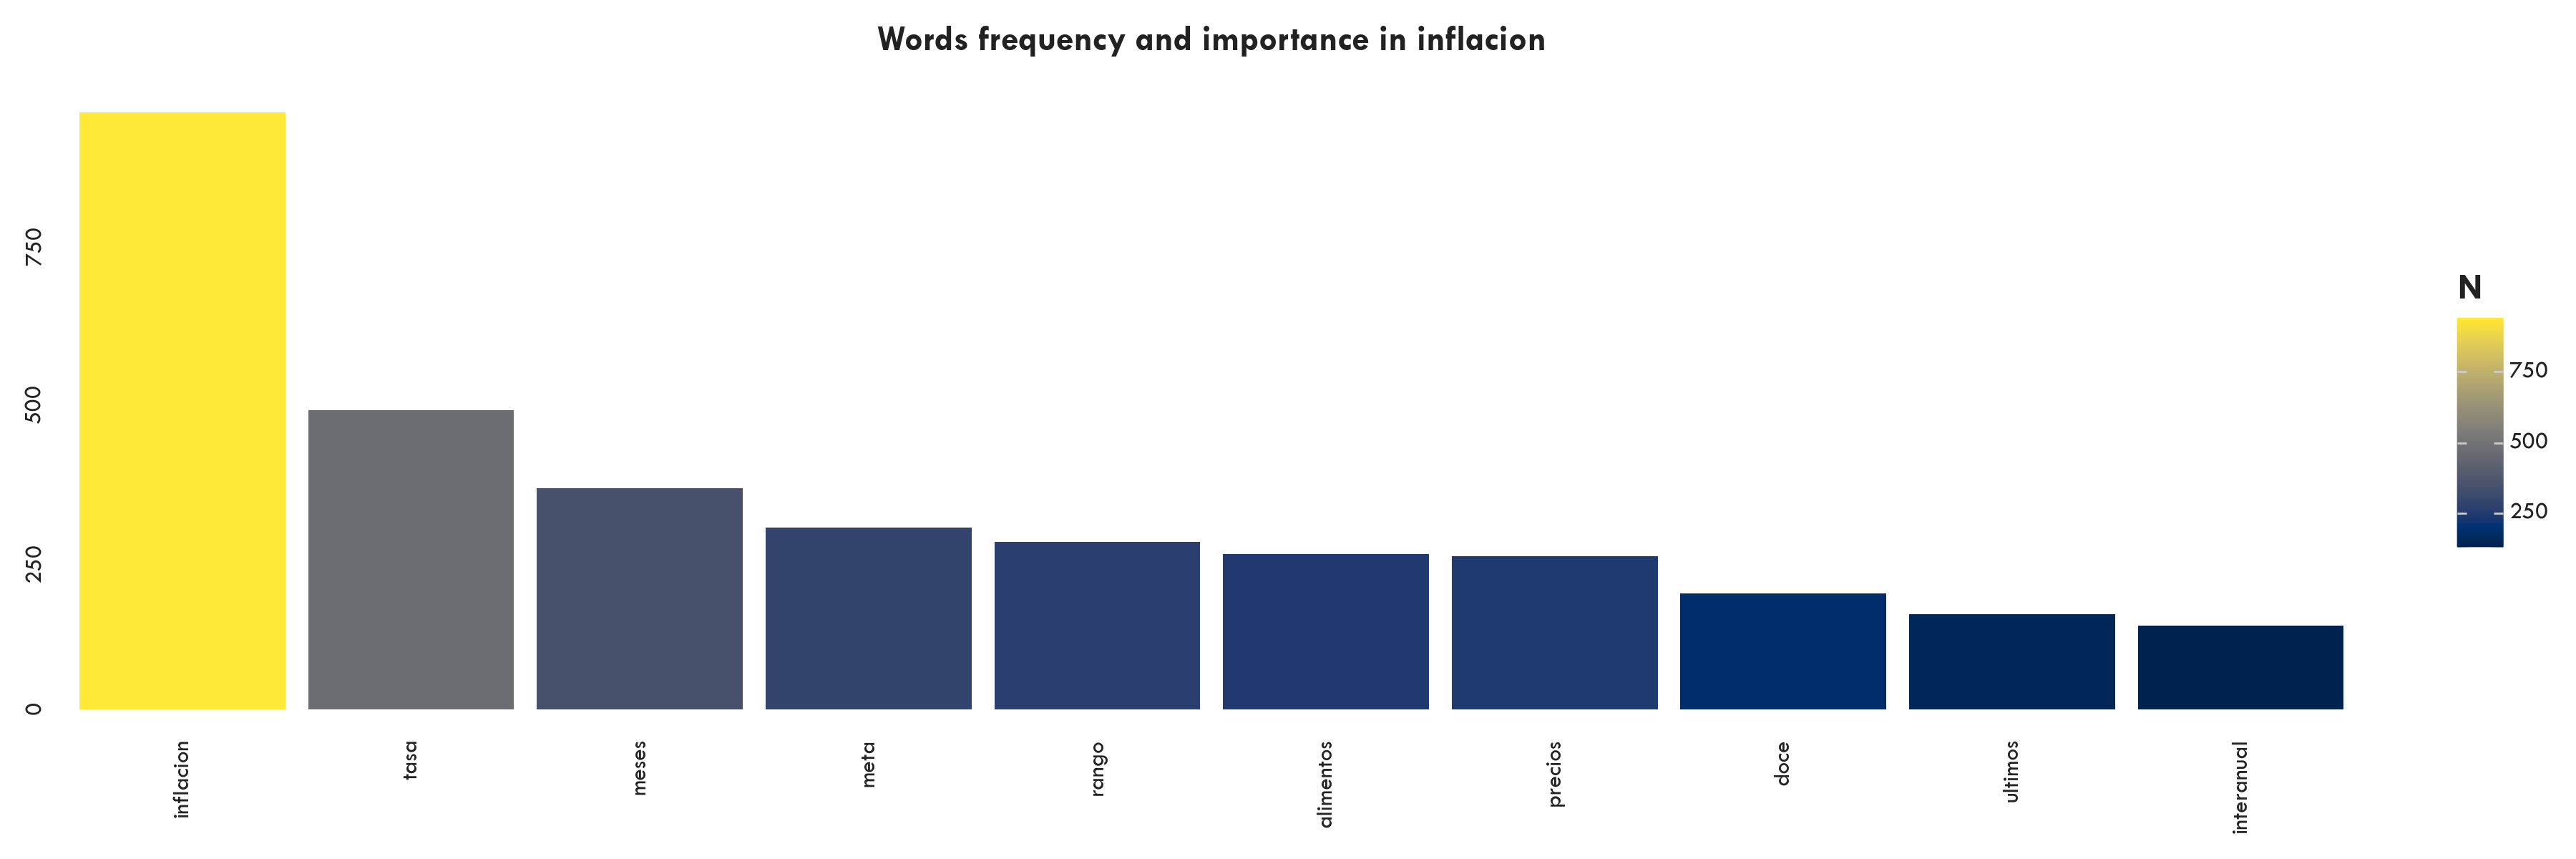

In [5]:
# Understanding word/phrase frequency - monograms
monograms = pd.DataFrame(monograms.explode())
monograms = monograms.groupby('MONOGRAMS').agg(N = pd.NamedAgg('MONOGRAMS','count')).reset_index(drop=False)
monograms = monograms.sort_values('N',ascending=False).reset_index(drop=True)
monograms['N_CUM'] = monograms['N'].cumsum()
monograms['PCT'] = monograms['N_CUM']/np.sum(monograms['N'])

plot = ggplot(monograms.iloc[:10,:])
plot = plot + geom_bar(aes(f'reorder(MONOGRAMS,-N)','N',fill='N'), stat='identity')
plot = plot + ggtitle(f'Words frequency and importance in {x.lower()}')
plot = plot + scale_y_continuous(labels=label_comma())
plot = plot + scale_fill_continuous(cmap_name='cividis',labels=label_comma())
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_title=element_blank(),axis_ticks = element_blank(),axis_line = element_blank(),axis_text=element_text(family="Tw Cen MT",size=12,color="#222222",rotation=90))
plot = plot + theme(legend_background = element_blank(),legend_title=element_text(family="Tw Cen MT",size=18,color="#222222",face='bold'),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot = plot + theme(figure_size=(18,6))
plot

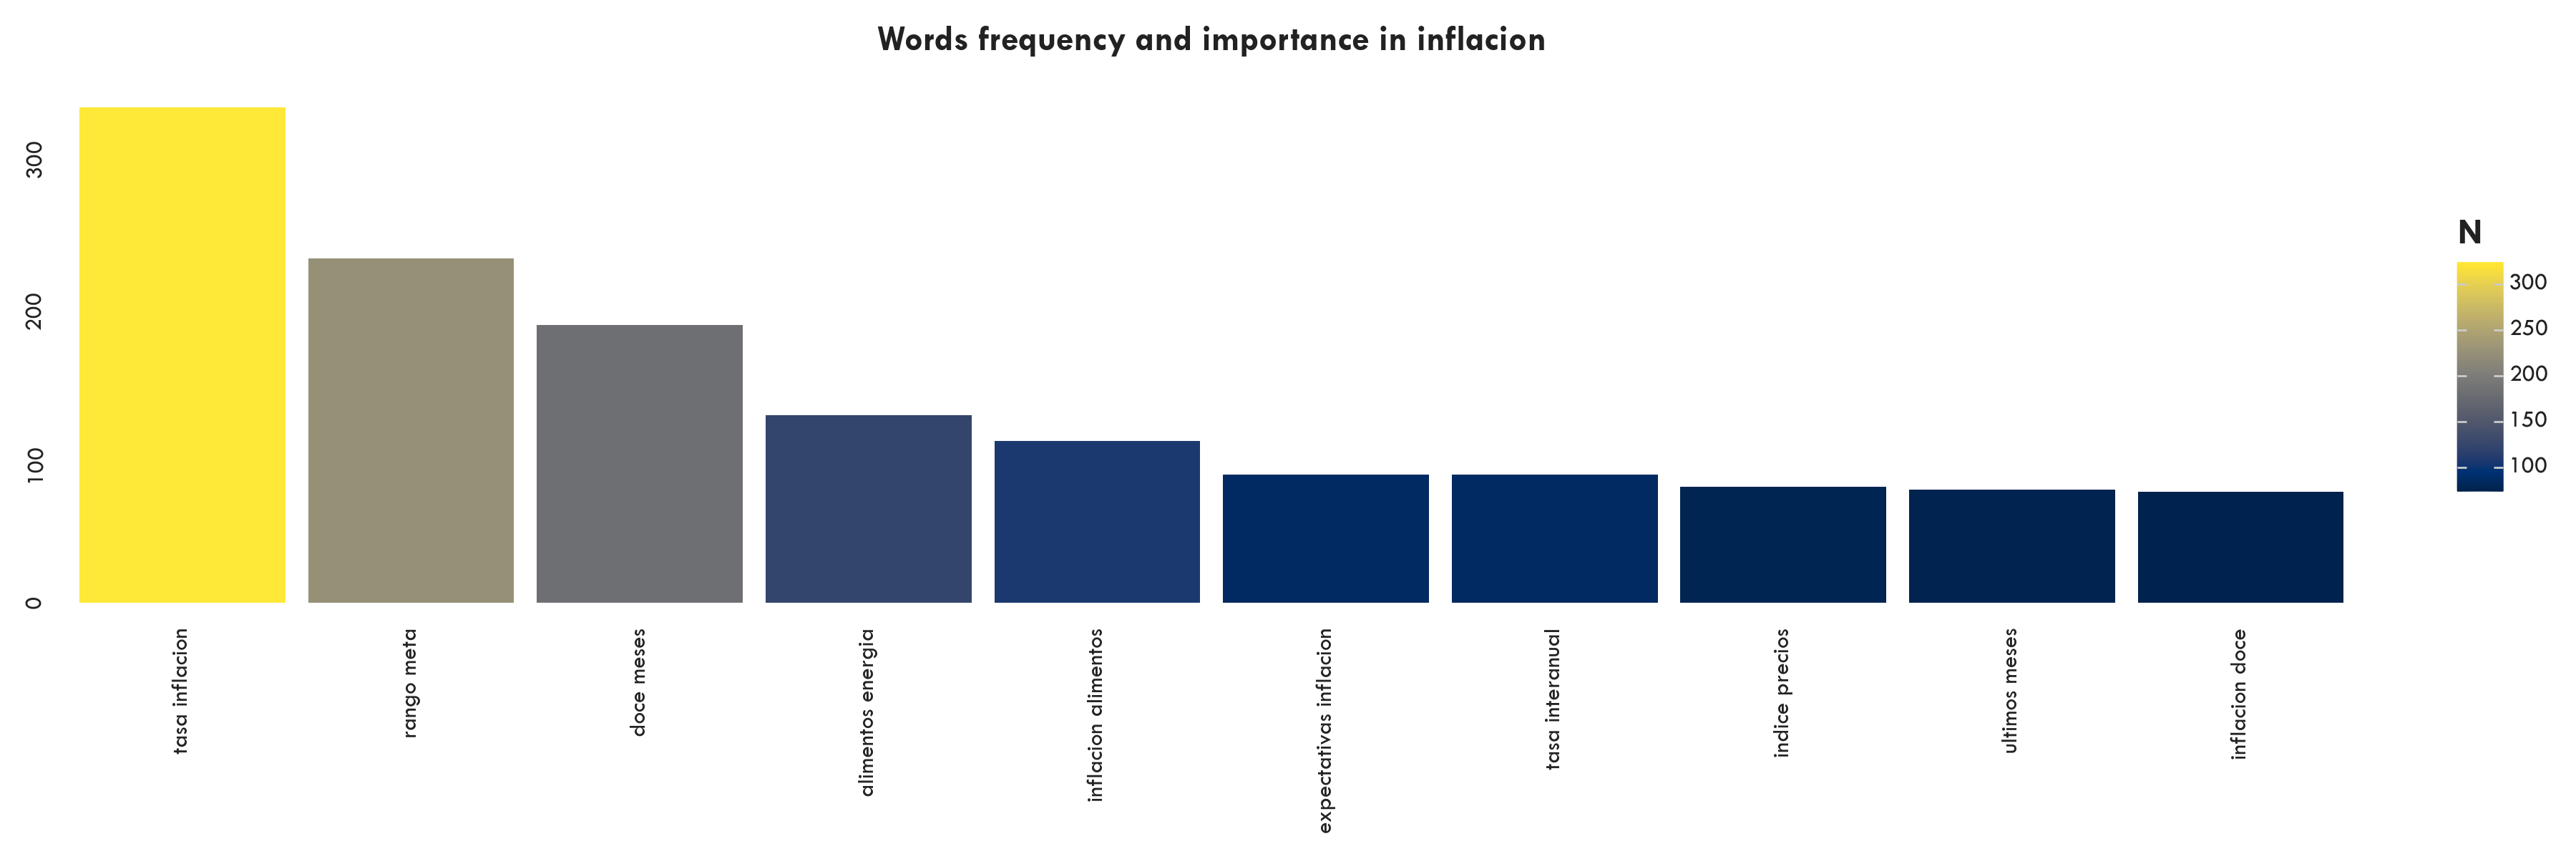

In [6]:
# Understanding word/phrase frequency - bigrams
bigrams = pd.DataFrame(bigrams.explode())
bigrams = bigrams.groupby('BIGRAMS').agg(N = pd.NamedAgg('BIGRAMS','count')).reset_index(drop=False)
bigrams = bigrams.sort_values('N',ascending=False).reset_index(drop=True)
bigrams['N_CUM'] = bigrams['N'].cumsum()
bigrams['PCT'] = bigrams['N_CUM']/np.sum(bigrams['N'])

plot = ggplot(bigrams.iloc[:10,:])
plot = plot + geom_bar(aes(f'reorder(BIGRAMS,-N)','N',fill='N'), stat='identity')
plot = plot + ggtitle(f'Words frequency and importance in {x.lower()}')
plot = plot + scale_y_continuous(labels=label_comma())
plot = plot + scale_fill_continuous(cmap_name='cividis',labels=label_comma())
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_title=element_blank(),axis_ticks = element_blank(),axis_line = element_blank(),axis_text=element_text(family="Tw Cen MT",size=12,color="#222222",rotation=90))
plot = plot + theme(legend_background = element_blank(),legend_title=element_text(family="Tw Cen MT",size=18,color="#222222",face='bold'),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot = plot + theme(figure_size=(18,6))
plot

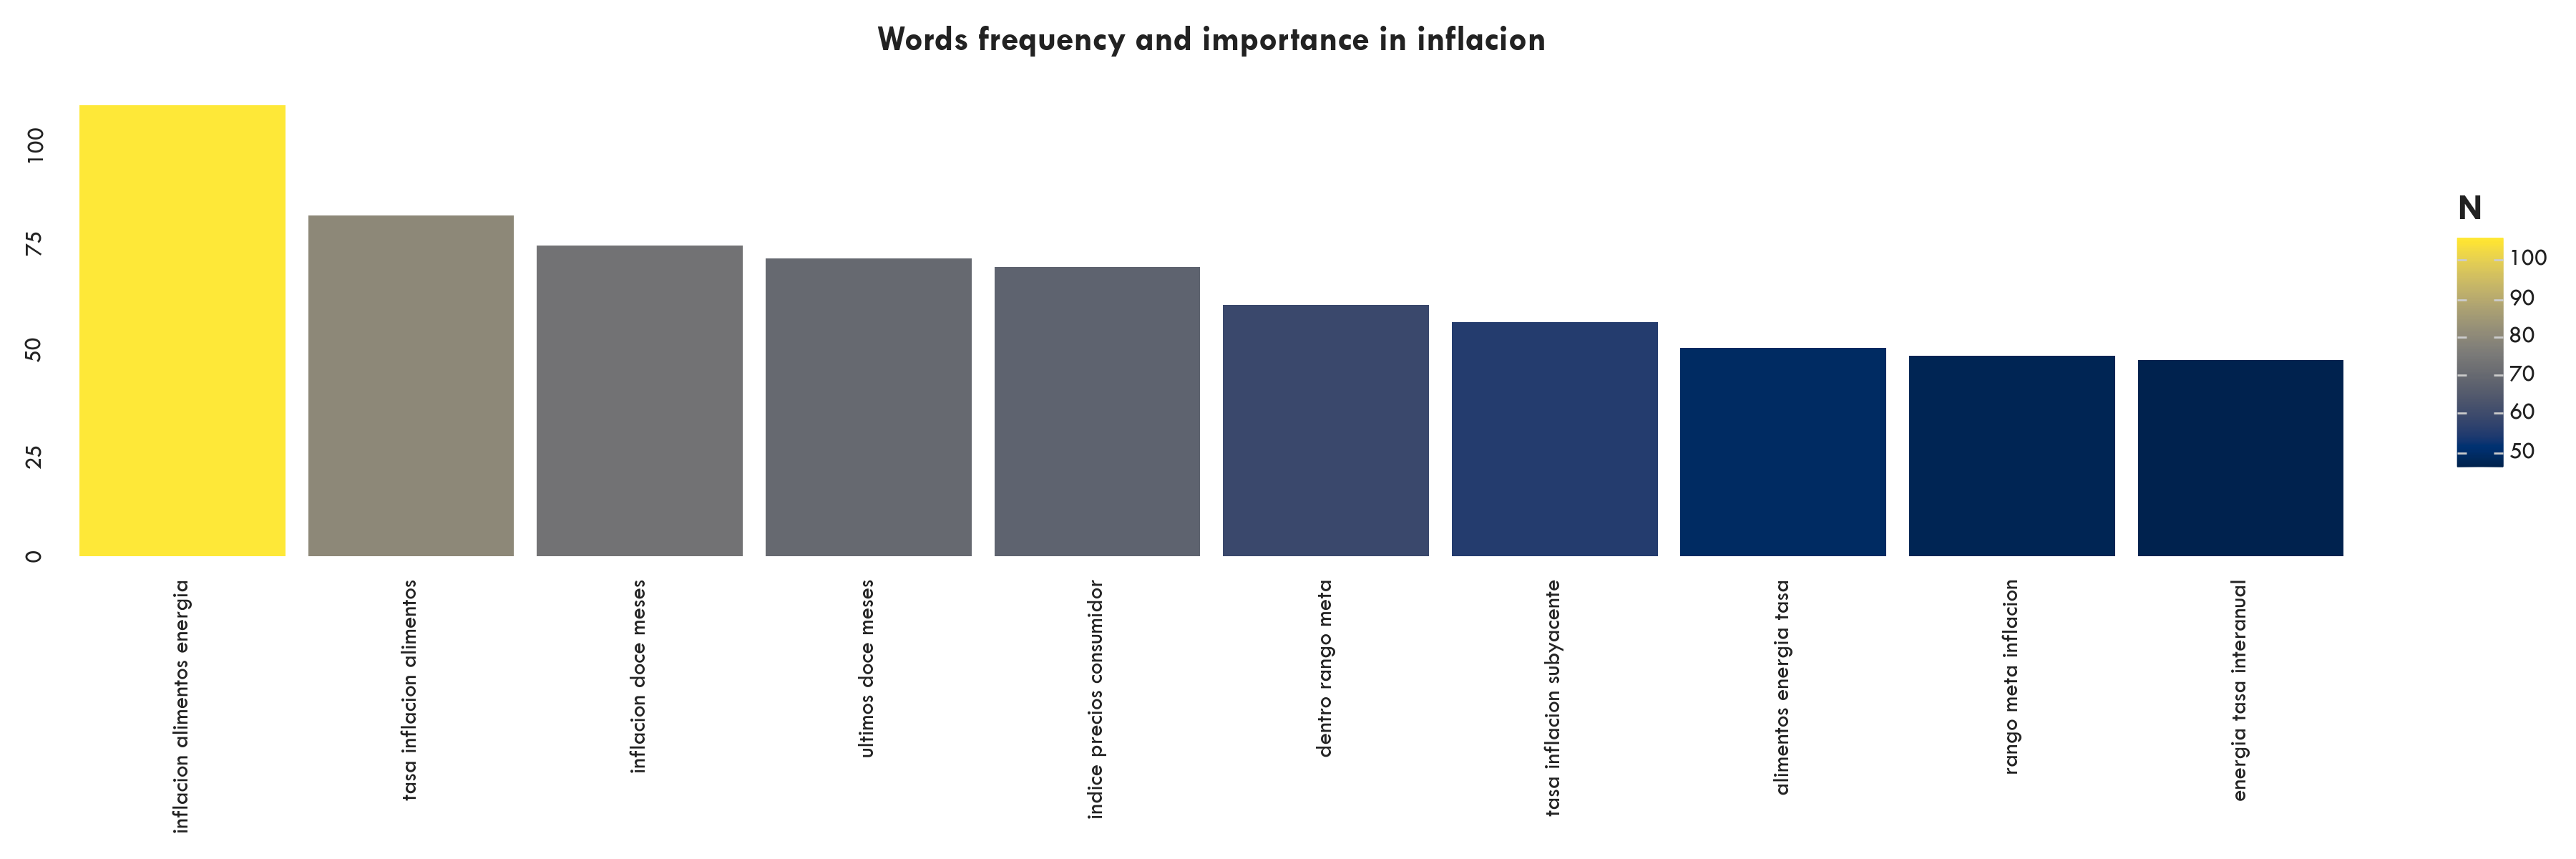

In [7]:
# Understanding word/phrase frequency - trigrams
trigrams = pd.DataFrame(trigrams.explode())
trigrams = trigrams.groupby('TRIGRAMS').agg(N = pd.NamedAgg('TRIGRAMS','count')).reset_index(drop=False)
trigrams = trigrams.sort_values('N',ascending=False).reset_index(drop=True)
trigrams['N_CUM'] = trigrams['N'].cumsum()
trigrams['PCT'] = trigrams['N_CUM']/np.sum(trigrams['N'])

plot = ggplot(trigrams.iloc[:10,:])
plot = plot + geom_bar(aes(f'reorder(TRIGRAMS,-N)','N',fill='N'), stat='identity')
plot = plot + ggtitle(f'Words frequency and importance in {x.lower()}')
plot = plot + scale_y_continuous(labels=label_comma())
plot = plot + scale_fill_continuous(cmap_name='cividis',labels=label_comma())
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_title=element_blank(),axis_ticks = element_blank(),axis_line = element_blank(),axis_text=element_text(family="Tw Cen MT",size=12,color="#222222",rotation=90))
plot = plot + theme(legend_background = element_blank(),legend_title=element_text(family="Tw Cen MT",size=18,color="#222222",face='bold'),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot = plot + theme(figure_size=(18,6))
plot

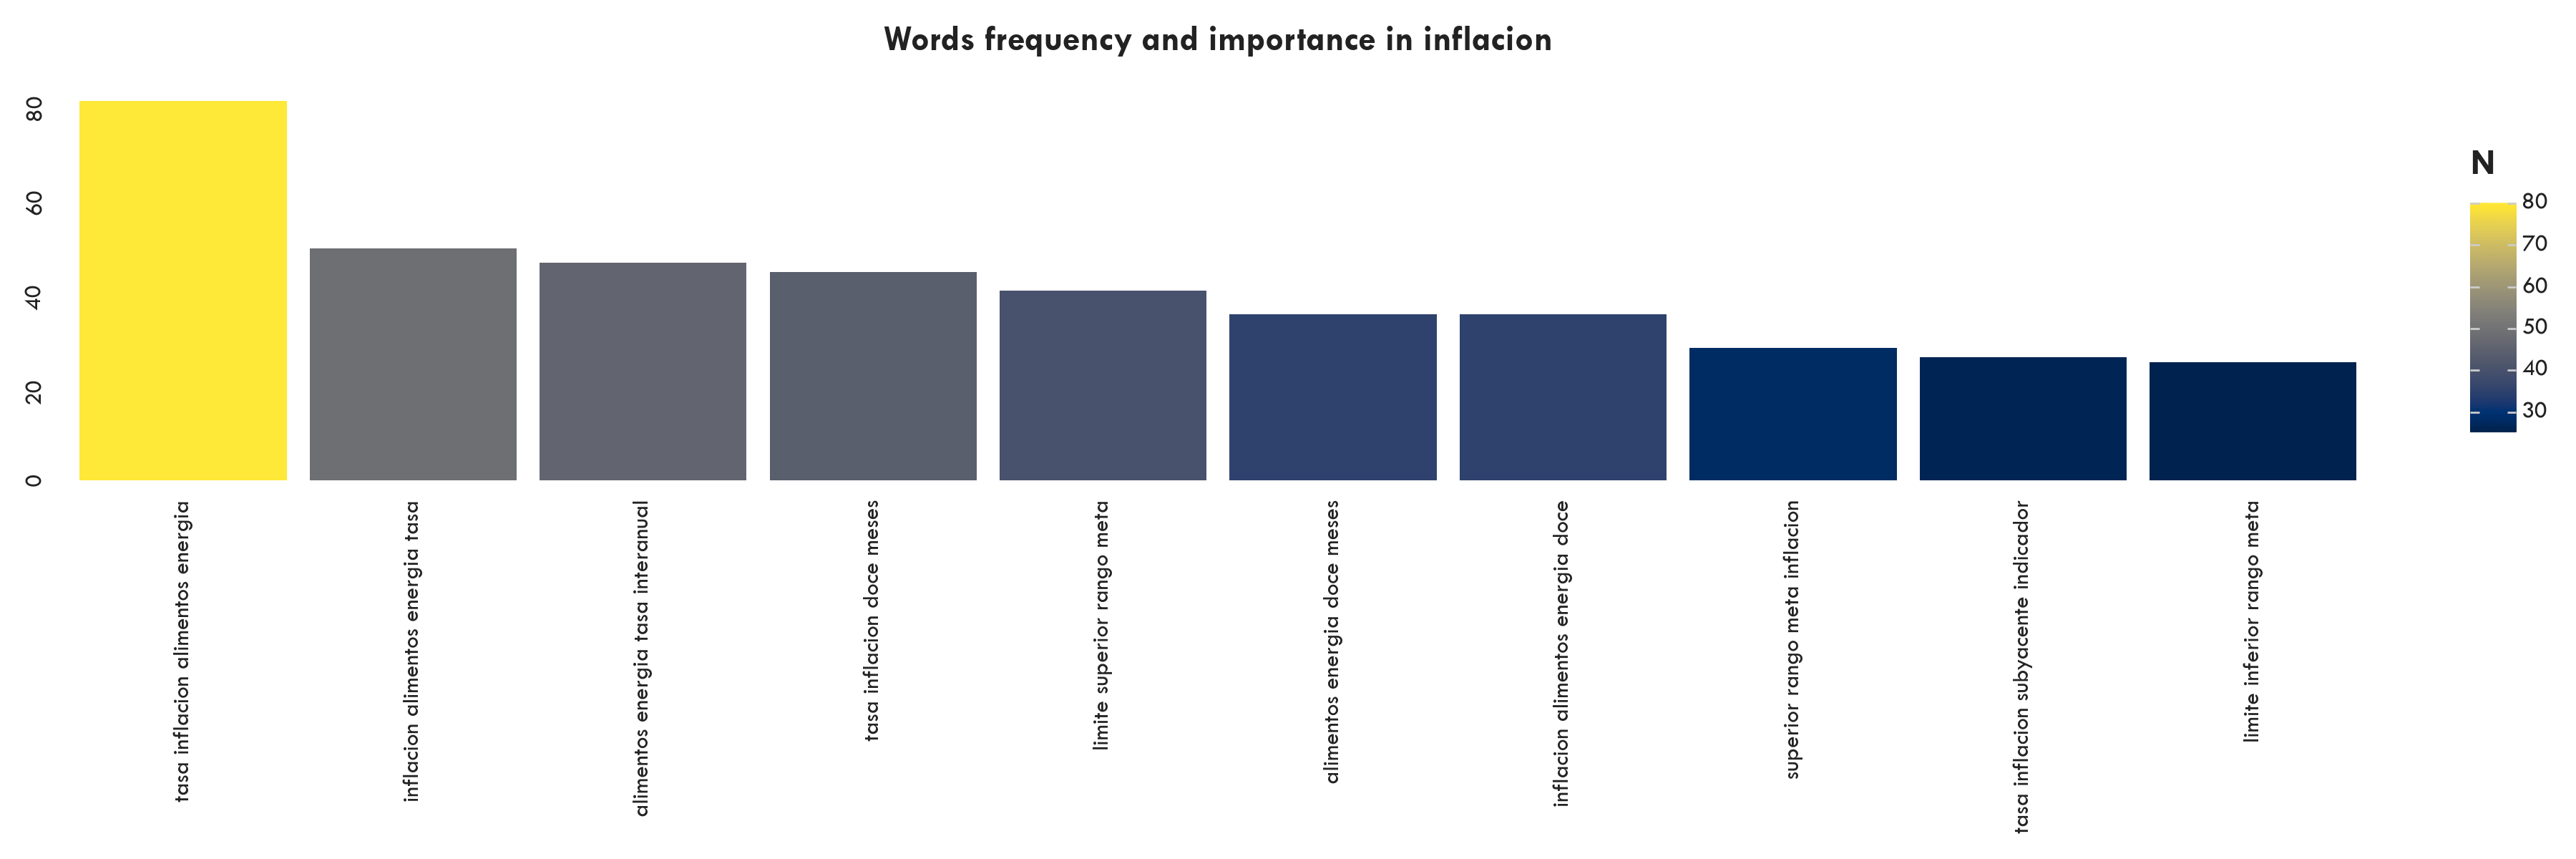

In [8]:
# Understanding word/phrase frequency - quadrigrams
quadrigrams = pd.DataFrame(quadrigrams.explode())
quadrigrams = quadrigrams.groupby('QUADRIGRAMS').agg(N = pd.NamedAgg('QUADRIGRAMS','count')).reset_index(drop=False)
quadrigrams = quadrigrams.sort_values('N',ascending=False).reset_index(drop=True)
quadrigrams['N_CUM'] = quadrigrams['N'].cumsum()
quadrigrams['PCT'] = quadrigrams['N_CUM']/np.sum(quadrigrams['N'])

plot = ggplot(quadrigrams.iloc[:10,:])
plot = plot + geom_bar(aes(f'reorder(QUADRIGRAMS,-N)','N',fill='N'), stat='identity')
plot = plot + ggtitle(f'Words frequency and importance in {x.lower()}')
plot = plot + scale_y_continuous(labels=label_comma())
plot = plot + scale_fill_continuous(cmap_name='cividis',labels=label_comma())
plot = plot + theme(plot_title=element_text(family="Tw Cen MT",size=18,face="bold",color="#222222"))
plot = plot + theme(panel_grid_minor=element_blank(), panel_grid_major_y=element_blank(),panel_grid_major_x=element_blank(),panel_background=element_blank())
plot = plot + theme(axis_title=element_blank(),axis_ticks = element_blank(),axis_line = element_blank(),axis_text=element_text(family="Tw Cen MT",size=12,color="#222222",rotation=90))
plot = plot + theme(legend_background = element_blank(),legend_title=element_text(family="Tw Cen MT",size=18,color="#222222",face='bold'),legend_text=element_text(family="Tw Cen MT",size=12,color="#222222"),legend_key=element_blank())
plot = plot + theme(figure_size=(18,6))
plot

# Generating contextual word embeddings
Different pretrained transformer-based models are evaluated. These models can classified as BERT-based models and RoBERTa-based models. The key difference between these two architectures is that in RoBERTa, the masking is performed during training time whereas in BERT the masking is performed at the beginning of the training. The architectures based on BERT are: (i) BETO, the Spanish version of BERT; two novel lightweight versions: (ii) ALBETO and (iii) Distilled BETO, and (iv) multilingual BERT (mBERT). The architectures based on RoBERTa are (i) MarIA, (ii) BERTIN and (iii) XLM. It is important to bear in mind that given that these kinds of embeddings are very time consuming, they are difficult to combine with other feature sets. Therefore, the fixed representation of the [CLS] token is extracted. Then, this representation is used to combine the contextual embeddings more easily with the rest of the feature sets.

### Separate dataset into training and test dat
The training data set is split into two sets: a train set with 80% of the data and a validation set with 20% of the data.

In [9]:
# Label dictionary
lab_dict = {'Inflacion':0,'Otros':1,'Politica monetaria':2,'Crecimiento economico':3,'Sector externo':4}
notas_df['TOPIC'] = notas_df['TOPIC'].apply(lambda x: lab_dict[x]).astype(int)

# Set complete_data to True, if you don't want to split data
complete_data = False

X = notas_df.NOTA_TK
y = notas_df.TOPIC

df = pd.merge(X,y,left_index=True,right_index=True)
df.columns = ['sentence','label']

if complete_data is False:
    df_train, df_test, = train_test_split(df, stratify=df['label'], test_size=0.4, random_state=42)
    print('Data is split into 60% train and 40% validation sets.')
else:
    df_train, df_test = df, df
    print('Data is not split.')
    
print('There are ' + str(len(df_train)) + ' training labels')
print('There are ' + str(len(df_test)) + ' validation labels')    

Data is split into 60% train and 40% validation sets.
There are 1210 training labels
There are 807 validation labels


### Set up the GPU
Since we'll be training a large neural network it's best to utilize these features.

In [10]:
if torch.cuda.is_available():
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available')

There are 1 GPU(s) available.
Device name: NVIDIA GeForce GTX 1050 Ti


### Fine-tuning Large Language Models
Hugging Face's transformer library includes pre-trained model weights and PyTorch implementations of cutting-edge NLP models like BERT (from Google) and GPT (from OpenAI).

The model predicts five possible classification values for each input sentence:
* **Inflacion**: Labeled as 0
* **Otros**: Labeled as 1
* **Politica monetaria**: Labeled as 2
* **Crecimiento economico**: Labeled as 3
* **Sector externo**: Labeled as 4

We will fine-tune the following large language models and compare the results on our dataset:
* **BETO**: Spanish version of BERT
* **mBERT**: Multilingual version of BERT
* **MarIA**: Spanish version of RoBERTa

#### BETO

BETO is a BERT model trained on a big Spanish corpus. BETO is of size similar to a BERT-Base and was trained with the Whole Word Masking technique. BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the [CLS] token is used as the features of the sequence to feed a classifier.

The transformers library has the BertForSequenceClassification class which is designed for classification tasks.

In [11]:
# Define if you want to use gpu or not
gpu = False
if gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [12]:
# Load pre-trained BERT model and tokenizer
model_name = 'BETO'
num_labels = len(np.unique(y))
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', do_lower_case=False)
model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=num_labels).to(device)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

In [13]:
# Tokenize and prepare the datasets for fine-tuning
max_length = 512

dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=max_length), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=max_length), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/1210 [00:00<?, ? examples/s]

Map:   0%|          | 0/807 [00:00<?, ? examples/s]

In [14]:
# Define the training arguments
epochs = 5
batch_size = 32
learning_rate = 4e-6
gradient_accumulation_steps = 2

training_args = TrainingArguments(
    # output directory
    output_dir=os.path.join(gral_path,'models',model_name),
    # total number of training epochs
    num_train_epochs=epochs,
    # batch size per device during training          
    per_device_train_batch_size=batch_size,  
    # batch size for evaluation
    per_device_eval_batch_size=batch_size,   
    # number of warmup steps for learning rate scheduler
    warmup_steps=500,
    # strength of weight decay                
    weight_decay=0.01,
    # directory for storing logs               
    logging_dir=os.path.join(gral_path,'models',model_name,'log'), 
    learning_rate=learning_rate,
    logging_steps=10,
    evaluation_strategy='epoch',
    save_total_limit=1,
    gradient_accumulation_steps=gradient_accumulation_steps,
    no_cuda=True
)

In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = balanced_accuracy_score(labels, predictions)
    return {
        'accuracy' : acc,
        'f1-score': f1,
        'precision': precision,
        'recall': recall
    }

In [16]:
# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics
    )

# Train the model
trainer.train()

eval_loss_values = []
training_loss_values = []
tr_loss_value = None
for i in trainer.state.log_history:
    try:
        eval_loss_values.append(i['eval_loss'])
        training_loss_values.append(tr_loss_value)
    except:
        pass

    try:
        tr_loss_value = i['loss']
    except:
        pass

c:\Python311\Lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


  0%|          | 0/95 [00:00<?, ?it/s]

{'loss': 1.5858, 'learning_rate': 8e-08, 'epoch': 0.53}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.5616145133972168, 'eval_accuracy': 0.20098163855706214, 'eval_f1-score': 0.23596107014274229, 'eval_precision': 0.21764177725844677, 'eval_recall': 0.3271375464684015, 'eval_runtime': 1196.4913, 'eval_samples_per_second': 0.674, 'eval_steps_per_second': 0.022, 'epoch': 1.0}
{'loss': 1.5615, 'learning_rate': 1.6e-07, 'epoch': 1.05}
{'loss': 1.5528, 'learning_rate': 2.4e-07, 'epoch': 1.58}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.5344828367233276, 'eval_accuracy': 0.22136736661877862, 'eval_f1-score': 0.2552053108799292, 'eval_precision': 0.2525877724230314, 'eval_recall': 0.3878562577447336, 'eval_runtime': 1218.1662, 'eval_samples_per_second': 0.662, 'eval_steps_per_second': 0.021, 'epoch': 2.0}
{'loss': 1.5396, 'learning_rate': 3.2e-07, 'epoch': 2.11}
{'loss': 1.538, 'learning_rate': 4e-07, 'epoch': 2.63}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.493010401725769, 'eval_accuracy': 0.2104822912771666, 'eval_f1-score': 0.2363965004084691, 'eval_precision': 0.25519654457654584, 'eval_recall': 0.38661710037174724, 'eval_runtime': 1192.9354, 'eval_samples_per_second': 0.676, 'eval_steps_per_second': 0.022, 'epoch': 3.0}
{'loss': 1.5082, 'learning_rate': 4.8e-07, 'epoch': 3.16}
{'loss': 1.487, 'learning_rate': 5.6e-07, 'epoch': 3.68}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.441521406173706, 'eval_accuracy': 0.20721646035463367, 'eval_f1-score': 0.2303563909222746, 'eval_precision': 0.24136975931060303, 'eval_recall': 0.3853779429987608, 'eval_runtime': 1188.545, 'eval_samples_per_second': 0.679, 'eval_steps_per_second': 0.022, 'epoch': 4.0}
{'loss': 1.468, 'learning_rate': 6.4e-07, 'epoch': 4.21}
{'loss': 1.4386, 'learning_rate': 7.2e-07, 'epoch': 4.74}


  0%|          | 0/26 [00:00<?, ?it/s]

{'eval_loss': 1.3796443939208984, 'eval_accuracy': 0.21936288128936537, 'eval_f1-score': 0.2543990333143357, 'eval_precision': 0.42033974966404447, 'eval_recall': 0.3990086741016109, 'eval_runtime': 1190.2093, 'eval_samples_per_second': 0.678, 'eval_steps_per_second': 0.022, 'epoch': 5.0}
{'train_runtime': 35691.9848, 'train_samples_per_second': 0.17, 'train_steps_per_second': 0.003, 'train_loss': 1.5147374153137207, 'epoch': 5.0}


In [17]:
# Evaluate the model
model.eval()
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # Set up the data collator to avoid padding the labels
trainer = Trainer(model=model, data_collator=data_collator) # Set up the trainer with the test data
y_prob, y_true, metrics = trainer.predict(test_dataset=dataset_val)
y_pred = y_prob.argmax(axis=1)

  0%|          | 0/101 [00:00<?, ?it/s]

In [18]:
# Classification Report
label_names = ["0", "1", "2", "3", "4"]
label_names = ['Inflacion', 'Otros', 'Politica Monetaria', 'Crecimiento economico', 'Sector externo']
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=label_names))

Classification Report:
                       precision    recall  f1-score   support

            Inflacion       0.40      0.99      0.57       305
                Otros       0.41      0.08      0.14       196
   Politica Monetaria       1.00      0.02      0.04       138
Crecimiento economico       0.00      0.00      0.00       102
       Sector externo       0.00      0.00      0.00        66

             accuracy                           0.40       807
            macro avg       0.36      0.22      0.15       807
         weighted avg       0.42      0.40      0.25       807



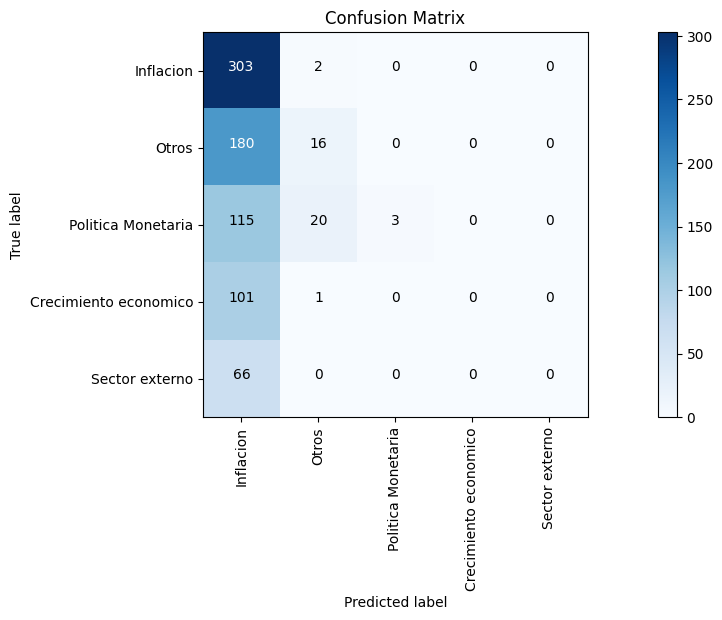

In [19]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmap = plt.cm.Blues
normalize = False

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(18,5))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names, rotation=90 )
plt.yticks(tick_marks, label_names)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

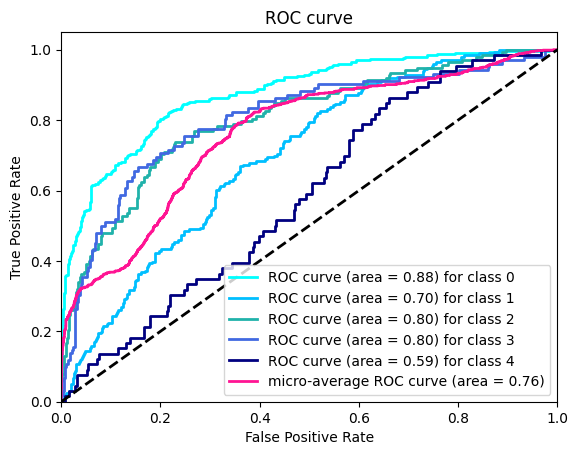

In [20]:
# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred_proba = y_prob.reshape((-1, num_labels))  # Reshape y_pred_proba for 5-class classification
for i in range(num_labels):
    y_true_i = (y_true == i)
    y_pred_proba_i = y_pred_proba[:, i]
    fpr[i], tpr[i], _ = roc_curve(y_true_i, y_pred_proba_i)
    roc_auc[i] = roc_auc_score(y_true_i, y_pred_proba_i, multi_class='ovo')

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(y_true, classes=[0, 1, 2, 3, 4]).ravel(), y_pred_proba.ravel())
roc_auc["micro"] = roc_auc_score(label_binarize(y_true, classes=[0, 1, 2, 3, 4]), y_pred_proba, average="micro")

# Plot ROC curve
lw = 2
colors = cycle(['aqua', 'deepskyblue', 'lightseagreen', 'royalblue', 'navy'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw,
            label='micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

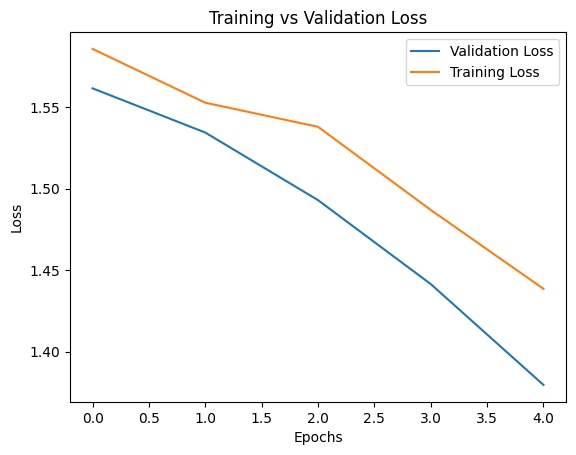

In [21]:
# Plot validation loss
val_losses = eval_loss_values
if val_losses is not None:
    plt.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss')
    plt.plot(np.arange(len(training_loss_values)), training_loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend(loc='upper right')
plt.show()

#### Explainable BETO and token importance

In [23]:
# Initiatiate the module
cls_explainer = SequenceClassificationExplainer(model, tokenizer)

In [43]:
def interpret_sentence(sentence, class_name):
  word_attributions = cls_explainer(sentence,class_name=class_name)
  return cls_explainer.visualize()

In [39]:
df_test['pred'] = y_pred
df_test.reset_index(drop=True,inplace=True)

In [40]:
# Exploring what makes the model think that a sentence belongs to inflacion
inflacion_texts = df_test.loc[df_test['label']==0,'sentence'].tolist()
otros_texts = df_test.loc[df_test['label']==1,'sentence'].tolist()
politicam_texts = df_test.loc[df_test['label']==2,'sentence'].tolist()
crecimecon_texts = df_test.loc[df_test['label']==3,'sentence'].tolist()
sectext_texts = df_test.loc[df_test['label']==4,'sentence'].tolist()

In [50]:
for sentence in range(3):
    interpret_sentence(inflacion_texts[sentence],class_name='LABEL_0')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.32),LABEL_0,2.87,[CLS] ello tasa inf ##lac ##ion doce meses ubic ##o mayor nivel registrado debido ani ##o pasado tasa mensual inf ##lac ##ion negativa [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.29),LABEL_0,2.50,[CLS] tasa inf ##lac ##ion subyac ##ente acumula tasa ultimo ##s meses [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.30),LABEL_0,1.97,[CLS] resultado inf ##lac ##ion ultimo ##s meses paso setiembre [SEP]


In [51]:
for sentence in range(3):
    interpret_sentence(otros_texts[sentence],class_name='LABEL_1')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_0 (0.23),LABEL_1,0.46,[CLS] medidas viene adoptando banco central estan orientadas lograr convergencia inf ##lac ##ion hacia rango meta [SEP]


In [52]:
for sentence in range(3):
    interpret_sentence(politicam_texts[sentence],class_name='LABEL_2')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,LABEL_0 (0.17),LABEL_2,-3.12,[CLS] nota informa ##tiv [UNK] banco central programa monetario banco central mantiene tasa interes referencia [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,LABEL_0 (0.19),LABEL_2,-1.29,[CLS] nota informativa programa monetario banco central mantiene tasa interes referencia [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,LABEL_0 (0.18),LABEL_2,-2.52,[CLS] operaciones compra temporal divisas ##es s ##w ##ap mantiene comisio ##n nivel implica costo efectivo anual minim ##o [SEP]


In [54]:
for sentence in range(3):
    interpret_sentence(crecimecon_texts[sentence],class_name='LABEL_3')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_0 (0.21),LABEL_3,1.36,[CLS] indicadores expectativas empresariales mantienen rango optimista aunque debajo niveles observado ##s primer trimestre [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_0 (0.22),LABEL_3,2.05,[CLS] indicadores adelantados expectativas econom ##ia muestran resultados mixto ##s manteniendo ##se mayor ##ia aun tramo pesim ##ista [SEP]


In [55]:
for sentence in range(3):
    interpret_sentence(sectext_texts[sentence],class_name='LABEL_4')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_0 (0.14),LABEL_4,-0.67,[CLS] condiciones clima ##ticas desfavor ##ables principales pais ##es productores granos elevado temporalmente cotizaciones internacionales com ##mod ##ities [SEP]
